In [129]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [130]:
from helpers import *

# Data prep

## ODB TSV

Data för 2011 - 2015

Läs in fil

In [156]:
df = pd.read_csv('../indata/ODB_TSV/ODB-Sysselsättning efter område, tid, ålder, sysselsättning och kön.txt', sep='\t', header=1)

Specificera indexering

In [157]:
df = df.set_index(['område', 'tid'])

Vänd ner samtliga kolumner i en kolumn

In [158]:
df = pd.DataFrame(df.stack())

Lyft ut index till kolumner igen

In [159]:
df = df.reset_index()

Sätt beskrivande kolumnnamn

In [160]:
df = df.rename(columns={'level_2': 'age_group_gender', 0: 'value', 'tid':'year'})

Splitta områdesnamn till endast baskod

In [161]:
df['område'] = df['område'].str.split(' ', 1, expand = True)
df = df.rename(columns={'område': 'BASKOD2010'})
df['BASKOD2010'] = df['BASKOD2010'].astype(str).astype(int)

Byt om `BASKOD2010` till entity-namnet

In [162]:
df = baskod2010tobasomrade(df)

Splitta ut `ageyeargender` till fyra separata kolumner

In [163]:
df['Kön'] = df['age_group_gender'].str.split().str[-1]

df['agegroup'] = df['age_group_gender'].str.split().str[0]

df['kategori'] = df['age_group_gender'].str.split().str[2:-1].str.join(' ')

Specificera ordningen på kolumnerna

In [164]:
df = df[['basomrade','year','kategori', 'Kön', 'agegroup', 'value']]

Specificera indexering

In [165]:
df = df.set_index(['basomrade'])

In [166]:
df['Kön'] = df['Kön'].astype('category')
df['Kön'].cat.categories = ['female', 'male']

In [167]:
df = df.groupby(['basomrade', 'year', 'kategori', 'Kön']).sum().reset_index()

Sätt `Kön` till en pandas category

## SCB CSV

Data för 2016

In [168]:
path = '../indata/supermappen/Tabell7A_ForvKonBas.csv'
df_csv = pd.read_csv(path,  encoding='latin1' , sep=';', decimal=',')

In [169]:
df_csv['year'] = 2016
df_csv = df_csv.rename(columns={
    'basomrade': 'BASKOD2010',
    'Forvkvinna': 'forv female',
    'ForvMan': 'forv male',
    'EjForvkvinna': 'ejforv female',
    'EjForvMan': 'ejforv male'
})

# from baskod to basomrade
df_csv = baskod2010tobasomrade(df_csv)

# drop irrelevant columns
df_csv = df_csv.drop(columns=['Totalt', 'BASKOD2010', 'BASKOD2000'])

# set index
df_csv = df_csv.set_index(['basomrade', 'year'])

# pivot columns into a single column
df_csv = pd.DataFrame(df_csv.stack()).reset_index()

# set column names
df_csv = df_csv.rename(columns={'level_2': 'group_gender', 0: 'value'})

# split group_gender into gender
df_csv['Kön'] = df_csv['group_gender'].str.split().str[-1]

# spllit group_gender into group
df_csv['kategori'] = df_csv['group_gender'].str.split().str[0]

# drop group_gender
df_csv = df_csv.drop(columns=['group_gender'])

# set gender column to type category
df_csv['Kön'] = df_csv['Kön'].astype('category')

In [170]:
# rename categories to match ODB TSV datasource
df_csv.loc[df_csv['kategori'] == 'forv', 'kategori'] = 'Förvärvsarbetande län 01'
df_csv.loc[df_csv['kategori'] == 'ejforv', 'kategori'] = 'Ej Förvärvsarbetande'

## Merge data sources

In [171]:
concat = pd.concat([df, df_csv], sort=False)

In [172]:
df.head()

,basomrade,year,kategori,Kön,value
0,1010120_skeppsbron,2011,Ej Förvärvsarbetande,female,34
1,1010120_skeppsbron,2011,Ej Förvärvsarbetande,male,46
2,1010120_skeppsbron,2011,Förvärvsarbetande ej län 01,female,5
3,1010120_skeppsbron,2011,Förvärvsarbetande ej län 01,male,0
4,1010120_skeppsbron,2011,Förvärvsarbetande län 01,female,112


In [173]:
df_csv.head()

,basomrade,year,value,Kön,kategori
0,1010120_skeppsbron,2016,135,female,Förvärvsarbetande län 01
1,1010120_skeppsbron,2016,146,male,Förvärvsarbetande län 01
2,1010120_skeppsbron,2016,62,female,Ej Förvärvsarbetande
3,1010120_skeppsbron,2016,73,male,Ej Förvärvsarbetande
4,1010130_munkbron,2016,327,female,Förvärvsarbetande län 01


In [174]:
concat.head()

,basomrade,year,kategori,Kön,value
0,1010120_skeppsbron,2011,Ej Förvärvsarbetande,female,34
1,1010120_skeppsbron,2011,Ej Förvärvsarbetande,male,46
2,1010120_skeppsbron,2011,Förvärvsarbetande ej län 01,female,5
3,1010120_skeppsbron,2011,Förvärvsarbetande ej län 01,male,0
4,1010120_skeppsbron,2011,Förvärvsarbetande län 01,female,112


In [175]:
#     combined = combined.rename(columns={'value': name})
combined = concat.copy()
combined['year'] = pd.to_datetime(combined['year'].astype('str'))
# combined[[combined['basomrade'] == '1130140_sabbatsberg' && combined['kategori'] == 'Ej Förvärvsarbetande']]#.plot()
#     (combined.groupby('year').mean()[name]).plot(legend=True, title='{title} (mean per basomrade)'.format(title=title))

# Antal förvärvsarbetande

In [184]:
concept = 'employed_aged_20_64'

In [185]:
nSys = df[df['kategori'].isin(['Förvärvsarbetande ej län 01', 'Förvärvsarbetande län 01'])]

In [186]:
nSysGender = nSys.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()

In [187]:
female, male = byGender(concept, nSysGender)

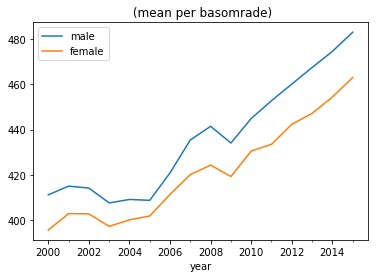

In [188]:
plotcombined(male, 'male', concept)
plotcombined(female, 'female')

In [189]:
nSys = nSys.groupby(['basomrade', 'year']).sum().reset_index()

In [190]:
total = appendNewDatapoints(concept, nSys)

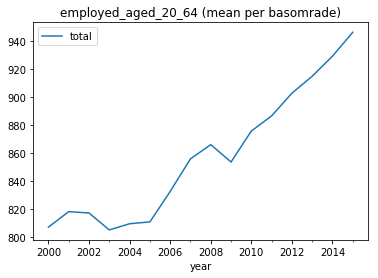

In [191]:
plotcombined(total, 'total', concept)

# Antal ej förvärvsarbetande

In [198]:
concept = 'unemployed_aged_20_64'

In [199]:
nNonSys = df[df['kategori'] == 'Ej Förvärvsarbetande']

In [200]:
nNonSysGender = nNonSys.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()

In [201]:
female, male = byGender(concept, nNonSysGender)

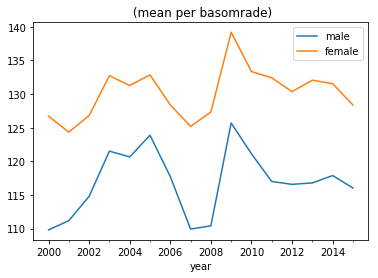

In [202]:
plotcombined(male, 'male', concept)
plotcombined(female, 'female')

In [203]:
nNonSys = nNonSys.groupby(['basomrade', 'year']).sum().reset_index()

In [204]:
total = appendNewDatapoints(concept, nNonSys)

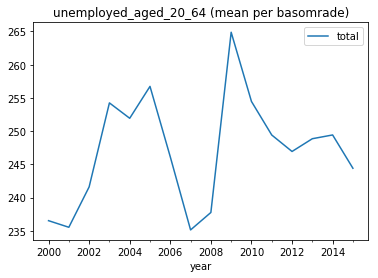

In [205]:
plotcombined(total, 'total', concept)

# Andel förvärvsarbetande

In [206]:
concept = 'employment_rate_20_64' #förvärvsarbetande

### Andel per kön

In [207]:
total = df.groupby(['basomrade', 'year', 'Kön']).sum().add_prefix('total_').reset_index()
# total = pd.merge(bygender, df)

In [208]:
bygender = df[df['kategori'].isin(['Förvärvsarbetande ej län 01', 'Förvärvsarbetande län 01'])]
bygender = bygender.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()

In [209]:
bygender = pd.merge(total, bygender)

In [210]:
bygender['rate'] = bygender['value'] / bygender['total_value']

In [211]:
bygender = bygender[['basomrade', 'year', 'Kön', 'rate']]
bygender = bygender.rename(columns={'rate': 'value'})

In [212]:
female, male = byGender(concept, bygender)

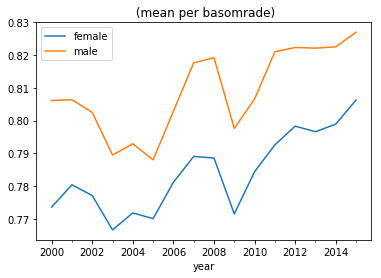

In [213]:
plotcombined(female, 'female', concept)
plotcombined(male, 'male')

### Andel totalt

In [214]:
total = df.groupby(['basomrade', 'year']).sum().add_prefix('total_').reset_index()

In [215]:
rate = df[df['kategori'].isin(['Förvärvsarbetande ej län 01', 'Förvärvsarbetande län 01'])]
rate = rate.groupby(['basomrade', 'year']).sum().reset_index()

In [216]:
rate = pd.merge(total, rate)

In [217]:
rate['rate'] = rate['value'] / rate['total_value']

In [218]:
rate = rate[['basomrade', 'year', 'rate']]
rate = rate.rename(columns={'rate': 'value'})

In [219]:
total = appendNewDatapoints(concept, rate)

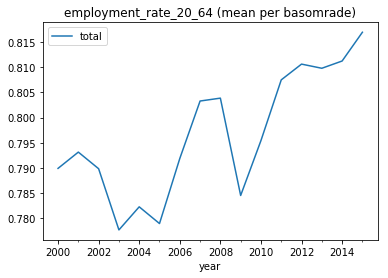

In [220]:
plotcombined(total, 'total', concept)